# Stochastic Variational Inference

Implementation of Stochastic Variational Inference (SVI) using [PyTorch](https://pytorch.org/), for the purpose of uncertainty quantification.

We'll consider the [OLS Regression Challenge](https://data.world/nrippner/ols-regression-challenge), which aims at predicting cancer mortality rates for US counties.

## Data Dictionary

* **TARGET_deathRate**: Dependent variable. Mean per capita (100,000) cancer mortalities (a)
* **avgAnnCount**: Mean number of reported cases of cancer diagnosed annually (a)
* **avgDeathsPerYear**: Mean number of reported mortalities due to cancer (a)
* **incidenceRate**: Mean per capita (100,000) cancer diagoses (a)
* **medianIncome**: Median income per county (b)
* **popEst2015**: Population of county (b)
* **povertyPercent**: Percent of populace in poverty (b)
* **studyPerCap**: Per capita number of cancer-related clinical trials per county (a)
* **binnedInc**: Median income per capita binned by decile (b)
* **MedianAge**: Median age of county residents (b)
* **MedianAgeMale**: Median age of male county residents (b)
* **MedianAgeFemale**: Median age of female county residents (b)
* **Geography**: County name (b)
* **AvgHouseholdSize**: Mean household size of county (b)
* **PercentMarried**: Percent of county residents who are married (b)
* **PctNoHS18_24**: Percent of county residents ages 18-24 highest education attained: less than high school (b)
* **PctHS18_24**: Percent of county residents ages 18-24 highest education attained: high school diploma (b)
* **PctSomeCol18_24**: Percent of county residents ages 18-24 highest education attained: some college (b)
* **PctBachDeg18_24**: Percent of county residents ages 18-24 highest education attained: bachelor's degree (b)
* **PctHS25_Over**: Percent of county residents ages 25 and over highest education attained: high school diploma (b)
* **PctBachDeg25_Over**: Percent of county residents ages 25 and over highest education attained: bachelor's degree (b)
* **PctEmployed16_Over**: Percent of county residents ages 16 and over employed (b)
* **PctUnemployed16_Over**: Percent of county residents ages 16 and over unemployed (b)
* **PctPrivateCoverage**: Percent of county residents with private health coverage (b)
* **PctPrivateCoverageAlone**: Percent of county residents with private health coverage alone (no public assistance) (b)
* **PctEmpPrivCoverage**: Percent of county residents with employee-provided private health coverage (b)
* **PctPublicCoverage**: Percent of county residents with government-provided health coverage (b)
* **PctPubliceCoverageAlone**: Percent of county residents with government-provided health coverage alone (b)
* **PctWhite**: Percent of county residents who identify as White (b)
* **PctBlack**: Percent of county residents who identify as Black (b)
* **PctAsian**: Percent of county residents who identify as Asian (b)
* **PctOtherRace**: Percent of county residents who identify in a category which is not White, Black, or Asian (b)
* **PctMarriedHouseholds**: Percent of married households (b)
* **BirthRate**: Number of live births relative to number of women in county (b)

Notes:
* (a): years 2010-2016
* (b): 2013 Census Estimates

In [1]:
import os
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from scipy.stats import binned_statistic

cwd = os.getcwd()
if cwd.endswith('notebook'):
    os.chdir('..')
    cwd = os.getcwd()

In [2]:
sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()

In [3]:
seed = 444
np.random.seed(seed);
torch.manual_seed(seed);
torch.set_default_dtype(torch.float64)

## Dataset

### Load

In [4]:
df = pd.read_csv(join(cwd, 'data/cancer_reg.csv'))
df.head()

,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,...,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
0,1397.0,469,164.9,489.8,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,...,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.0,70,161.3,411.6,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,...,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.0,50,174.7,349.7,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,...,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.0,202,194.8,430.4,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,...,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.0,26,144.4,350.1,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,...,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657


### Describe

In [5]:
df.describe()

,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,MedianAge,MedianAgeMale,...,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
count,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3.047000e+03,3047.000000,3047.000000,3047.000000,3047.000000,...,2438.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000,3047.000000
mean,606.338544,185.965868,178.664063,448.268586,47063.281917,1.026374e+05,16.878175,155.399415,45.272333,39.570725,...,48.453774,41.196324,36.252642,19.240072,83.645286,9.107978,1.253965,1.983523,51.243872,5.640306
std,1416.356223,504.134286,27.751511,54.560733,12040.090836,3.290592e+05,6.409087,529.628366,45.304480,5.226017,...,10.083006,9.447687,7.841741,6.113041,16.380025,14.534538,2.610276,3.517710,6.572814,1.985816
min,6.000000,3.000000,59.700000,201.300000,22640.000000,8.270000e+02,3.200000,0.000000,22.300000,22.400000,...,15.700000,13.500000,11.200000,2.600000,10.199155,0.000000,0.000000,0.000000,22.992490,0.000000
25%,76.000000,28.000000,161.200000,420.300000,38882.500000,1.168400e+04,12.150000,0.000000,37.700000,36.350000,...,41.000000,34.500000,30.900000,14.850000,77.296180,0.620675,0.254199,0.295172,47.763063,4.521419
50%,171.000000,61.000000,178.100000,453.549422,45207.000000,2.664300e+04,15.900000,0.000000,41.000000,39.600000,...,48.700000,41.100000,36.300000,18.800000,90.059774,2.247576,0.549812,0.826185,51.669941,5.381478
75%,518.000000,149.000000,195.200000,480.850000,52492.000000,6.867100e+04,20.400000,83.650776,44.000000,42.500000,...,55.600000,47.700000,41.550000,23.100000,95.451693,10.509732,1.221037,2.177960,55.395132,6.493677
max,38150.000000,14010.000000,362.800000,1206.900000,125635.000000,1.017029e+07,47.400000,9762.308998,624.000000,64.700000,...,78.900000,70.700000,65.100000,46.600000,100.000000,85.947799,42.619425,41.930251,78.075397,21.326165


### Plot distribution of target variable

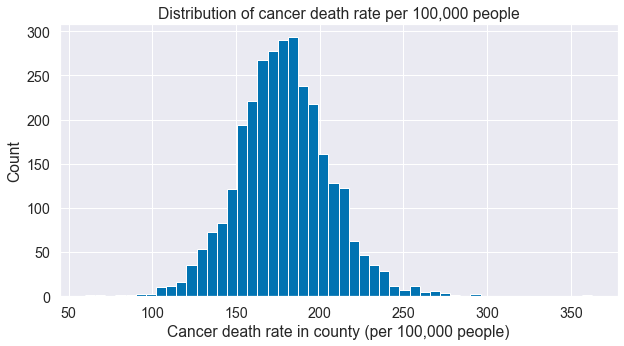

In [6]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
df['TARGET_deathRate'].hist(bins=50, ax=ax);
ax.set_title('Distribution of cancer death rate per 100,000 people');
ax.set_xlabel('Cancer death rate in county (per 100,000 people)');
ax.set_ylabel('Count');

### Define feature & target variables

In [7]:
target = 'TARGET_deathRate'
features = [
    col for col in df.columns
    if col not in [
        target, 
        'Geography',                # Label describing the county - each row has a different one
        'binnedInc',                # Redundant with median income?
        'PctSomeCol18_24',          # contains null values - ignoring for now
        'PctEmployed16_Over',       # contains null values - ignoring for now
        'PctPrivateCoverageAlone',  # contains null values - ignoring for now
    ]
]
print(len(features), 'features')

28 features


In [8]:
x = df[features].values
y = df[[target]].values
print(x.shape, y.shape)

(3047, 28) (3047, 1)


## Define model

In [9]:
class VariationalModel(torch.nn.Module):
    def __init__(
        self, 
        n_inputs,
        n_hidden,
        priors,
        x_scaler, 
        y_scaler,
        n_shared_layers=1,
    ):
        super().__init__()
        
        self.priors = priors
        self.x_scaler = x_scaler
        self.y_scaler = y_scaler
        self.jitter = 1e-6
        
        # Shared layers
        self.shared_layers = [
            torch.nn.Linear(n_inputs, n_hidden)
        ]
        if n_shared_layers > 1:
            for _ in range(n_shared_layers - 1):
                self.shared_layers.append(
                    torch.nn.Linear(n_hidden, n_hidden)
                )
        
        # Parameters for the mean 
        self.mean_loc_hidden = torch.nn.Linear(n_hidden, n_hidden)
        self.mean_loc = torch.nn.Linear(n_hidden, 1)
        self.mean_scale_hidden = torch.nn.Linear(n_hidden, n_hidden)
        self.mean_scale = torch.nn.Linear(n_hidden, 1)
        
        # Parameters for the standard deviation
        self.std_loc_hidden = torch.nn.Linear(n_hidden, n_hidden)
        self.std_loc = torch.nn.Linear(n_hidden, 1)
        self.std_scale_hidden = torch.nn.Linear(n_hidden, n_hidden)
        self.std_scale = torch.nn.Linear(n_hidden, 1)
        
    def encoder(self, x):
        shared = self.x_scaler(x)
        
        for layer in self.shared_layers:
            shared = layer(shared)
            shared = F.relu(shared)
            #shared = self.dropout(shared)
        
        # Parametrization of the mean (normal)
        mean_loc = self.mean_loc_hidden(shared)
        mean_loc = F.relu(mean_loc)
        mean_loc = self.mean_loc(mean_loc)
        
        mean_scale = self.mean_scale_hidden(shared)
        mean_scale = F.relu(mean_scale)
        mean_scale = F.softplus(self.mean_scale(mean_scale)) + self.jitter
        
        # Parametrization of the standard deviation (log normal)
        std_loc = self.std_loc_hidden(shared)
        std_loc = F.relu(std_loc)
        std_loc = self.std_loc(std_loc)
        
        std_scale = self.std_scale_hidden(shared)
        std_scale = F.relu(std_scale)
        std_scale = F.softplus(self.std_scale(std_scale)) + self.jitter    
        
        return (
            torch.distributions.Normal(mean_loc, mean_scale),
            torch.distributions.LogNormal(std_loc, std_scale)
        )
    
    def decoder(self, mean, std):
        return torch.distributions.Normal(mean, std)
    
    def forward(self, x, sample_shape=torch.Size([])):
        mean_dist, std_dist = self.encoder(x)
        
        mean = mean_dist.rsample(sample_shape)
        std = std_dist.rsample(sample_shape) + self.jitter
        
        y_hat = self.decoder(mean, std)
        
        kl_divergence = None
        if self.priors is not None:
            kl_divergence1 = torch.distributions.kl.kl_divergence(mean_dist, self.priors[0])
            kl_divergence2 = torch.distributions.kl.kl_divergence(std_dist, self.priors[1])
            kl_divergence = kl_divergence1 + kl_divergence2
            
        return y_hat, kl_divergence


def compute_loss(model, x, y, kl_reg=0.1):
    """
    ELBO loss - https://en.wikipedia.org/wiki/Evidence_lower_bound
    """
    y_scaled = model.y_scaler(y)
    
    y_hat, kl_divergence = model(x)
    
    neg_log_likelihood = -y_hat.log_prob(y_scaled)
    
    if kl_divergence is not None:
        neg_log_likelihood += kl_reg * kl_divergence

    return torch.mean(neg_log_likelihood)


def compute_rmse(model, x_test, y_test):
    model.eval()
    y_hat, _ = model(x_test)
    pred = model.y_scaler.inverse_transform(y_hat.mean)
    return torch.sqrt(torch.mean((pred - y_test)**2))


def train_one_step(model, optimizer, x_batch, y_batch):
    model.train()
    optimizer.zero_grad()
    loss = compute_loss(model, x_batch, y_batch)
    loss.backward()
    optimizer.step()
    return loss

In [10]:
def train(model, optimizer, x_train, x_val, y_train, y_val, n_epochs, batch_size, scheduler=None, print_every=10):
    train_losses, val_losses = [], []
    for epoch in range(n_epochs):
        batch_indices = sample_batch_indices(x_train, y_train, batch_size)
        
        batch_losses_t, batch_losses_v, batch_rmse_v = [], [], []
        for batch_ix in batch_indices:
            b_train_loss = train_one_step(model, optimizer, x_train[batch_ix], y_train[batch_ix])

            model.eval()
            b_val_loss = compute_loss(model, x_val, y_val)
            b_val_rmse = compute_rmse(model, x_val, y_val)

            batch_losses_t.append(b_train_loss.detach().numpy())
            batch_losses_v.append(b_val_loss.detach().numpy())
            batch_rmse_v.append(b_val_rmse.detach().numpy())
            
        if scheduler is not None:
            scheduler.step()
            
        train_loss = np.mean(batch_losses_t)
        val_loss = np.mean(batch_losses_v)
        val_rmse = np.mean(batch_rmse_v)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if epoch == 0 or (epoch + 1) % print_every == 0:
            print(f'Epoch {epoch+1} | Validation loss = {val_loss:.4f} | Validation RMSE = {val_rmse:.4f}')
        
    _, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(range(1, n_epochs + 1), train_losses, label='Train loss')
    ax.plot(range(1, n_epochs + 1), val_losses, label='Validation loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Overview')
    ax.legend()
    
    return train_losses, val_losses


def sample_batch_indices(x, y, batch_size, rs=None):
    if rs is None:
        rs = np.random.RandomState()
    
    train_ix = np.arange(len(x))
    rs.shuffle(train_ix)
    
    n_batches = int(np.ceil(len(x) / batch_size))
    
    batch_indices = []
    for i in range(n_batches):
        start = i + batch_size
        end = start + batch_size
        batch_indices.append(
            train_ix[start:end].tolist()
        )

    return batch_indices

In [11]:
class StandardScaler(object):
    """
    Standardize data by removing the mean and scaling to unit variance.
    """
    def __init__(self):
        self.mean = None
        self.scale = None

    def fit(self, sample):
        self.mean = sample.mean(0, keepdim=True)
        self.scale = sample.std(0, unbiased=False, keepdim=True)
        return self

    def __call__(self, sample):
        return self.transform(sample)
    
    def transform(self, sample):
        return (sample - self.mean) / self.scale

    def inverse_transform(self, sample):
        return sample * self.scale + self.mean

## Split between training and validation sets

In [12]:
def compute_train_test_split(x, y, test_size):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    return (
        torch.from_numpy(x_train),
        torch.from_numpy(x_test),
        torch.from_numpy(y_train),
        torch.from_numpy(y_test),
    )

In [13]:
x_train, x_val, y_train, y_val = compute_train_test_split(x, y, test_size=0.2)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

torch.Size([2437, 28]) torch.Size([2437, 1])
torch.Size([610, 28]) torch.Size([610, 1])


## Train model

In [14]:
x_scaler = StandardScaler().fit(torch.from_numpy(x))
y_scaler = StandardScaler().fit(torch.from_numpy(y))

In [15]:
def lr_steep_schedule(epoch):
    threshold = 5
    if epoch < threshold:
        return 1.0
    
    multiplier = 2 / 10
    step_change = (epoch - threshold) // 300
    
    return multiplier * 0.5 ** (step_change)


def lr_simple_schedule(epoch):
    return 0.5 ** (epoch // 200)

In [16]:
def make_priors(y_train, y_scaler):
    std = torch.Tensor((0.5,))
    scale = torch.Tensor((0.2,))
    
    std_loc = torch.log(std**2 / torch.sqrt(std**2 + scale**2))
    std_scale = torch.sqrt(torch.log(1 + scale**2 / std**2))
    
    return [
        torch.distributions.Normal(0, 1),
        torch.distributions.LogNormal(std_loc, std_scale),
    ]

40,804 trainable parameters

Epoch 1 | Validation loss = 2.1251 | Validation RMSE = 31.5151
Epoch 50 | Validation loss = 1.3677 | Validation RMSE = 20.3201
Epoch 100 | Validation loss = 1.2999 | Validation RMSE = 19.8506
Epoch 150 | Validation loss = 1.2854 | Validation RMSE = 19.5741
Epoch 200 | Validation loss = 1.2695 | Validation RMSE = 19.4597
Epoch 250 | Validation loss = 1.2747 | Validation RMSE = 19.3205
Epoch 300 | Validation loss = 1.3003 | Validation RMSE = 19.5134
Epoch 350 | Validation loss = 1.2617 | Validation RMSE = 19.0837
Epoch 400 | Validation loss = 1.2400 | Validation RMSE = 18.8530
Epoch 450 | Validation loss = 1.2662 | Validation RMSE = 18.9906
Epoch 500 | Validation loss = 1.2509 | Validation RMSE = 18.9645
Epoch 550 | Validation loss = 1.2512 | Validation RMSE = 18.8079
Epoch 600 | Validation loss = 1.2602 | Validation RMSE = 18.9772
Epoch 650 | Validation loss = 1.2475 | Validation RMSE = 18.8599
Epoch 700 | Validation loss = 1.2661 | Validation RMSE = 18.8974

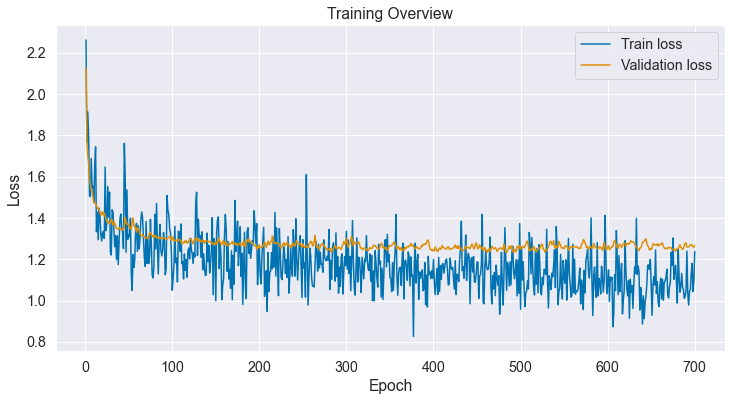

In [17]:
%%time

learning_rate = 1e-3
momentum = 0.9
weight_decay = 1e-4

n_epochs = 700
batch_size = 64
print_every = 50

n_hidden = 100
n_shared_layers = 1

priors = make_priors(y_train, y_scaler)

model = VariationalModel(
    n_inputs=x.shape[1],
    n_hidden=n_hidden,
    priors=priors,
    n_shared_layers=n_shared_layers,
    x_scaler=x_scaler, 
    y_scaler=y_scaler,
)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{pytorch_total_params:,} trainable parameters')
print()

optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=learning_rate, 
    momentum=momentum, 
    nesterov=True,
    weight_decay=weight_decay,
)
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer, 
    lr_lambda=lr_steep_schedule,
)

train_losses, val_losses = train(
    model, 
    optimizer, 
    x_train, 
    x_val, 
    y_train, 
    y_val, 
    n_epochs=n_epochs, 
    batch_size=batch_size, 
    scheduler=scheduler, 
    print_every=print_every,
)

### Validation

In [18]:
y_dist, _ = model(x_val)
y_hat = model.y_scaler.inverse_transform(y_dist.mean)

In [19]:
val_rmse = float(compute_rmse(model, x_val, y_val).detach().numpy())
print(f'Validation RMSE = {val_rmse:.2f}')

Validation RMSE = 18.59


In [20]:
val_r2 = r2_score(
    y_val.detach().numpy().flatten(),
    y_hat.detach().numpy().flatten(),
)
print(f'Validation $R^2$ = {val_r2:.2f}')

Validation $R^2$ = 0.53


In [21]:
def plot_results(y_true, y_pred):
    _, ax = plt.subplots(1, 1, figsize=(7, 7))
    palette = sns.color_palette()
    
    min_value = min(np.amin(y_true), np.amin(y_pred))
    max_value = max(np.amax(y_true), np.amax(y_pred))
    y_mid = np.linspace(min_value, max_value)
    
    ax.plot(y_mid, y_mid, '--', color=palette[1])
    ax.scatter(y_true, y_pred, color=palette[0], alpha=0.5);
    
    return ax

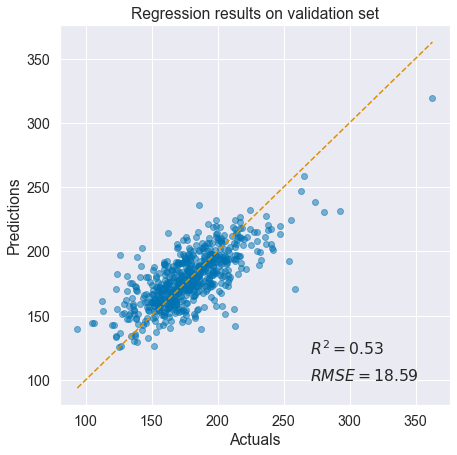

In [22]:
ax = plot_results(
    y_val.detach().numpy().flatten(),
    y_hat.detach().numpy().flatten(),
);

ax.text(270, 120, f'$R^2 = {val_r2:.2f}$')
ax.text(270, 100, f'$RMSE = {val_rmse:.2f}$')
    
ax.set_xlabel('Actuals');
ax.set_ylabel('Predictions');
ax.set_title('Regression results on validation set');

## Uncertainty

In [23]:
def make_predictions(model, x):
    mean_dist, std_dist = model.encoder(x)
    
    inv_tr = model.y_scaler.inverse_transform
    
    y_hat = inv_tr(mean_dist.mean)
    
    # Recover standard deviation's original scale
    std_from_mean_dist = inv_tr(mean_dist.mean + mean_dist.stddev) - y_hat
    std_from_std_dist = inv_tr(mean_dist.mean + std_dist.mean + std_dist.stddev) - y_hat
    
    return y_hat, std_from_mean_dist, std_from_std_dist

In [24]:
y_hat, std_from_mean_dist , std_from_std_dist = make_predictions(model, x_val)
std = std_from_mean_dist + std_from_std_dist

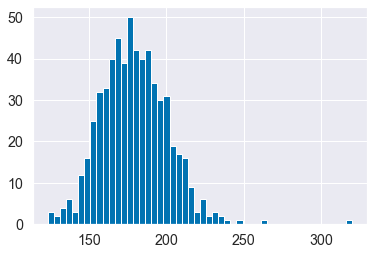

In [25]:
plt.hist(y_hat.detach().numpy().flatten(), bins=50);

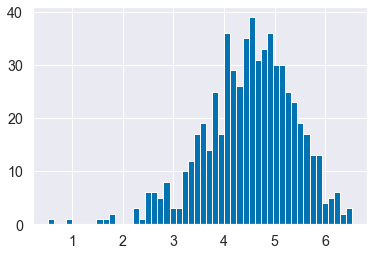

In [26]:
plt.hist(std_from_mean_dist.detach().numpy().flatten(), bins=50);

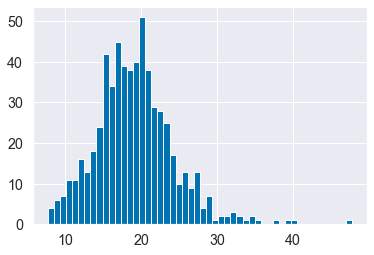

In [27]:
plt.hist(std_from_std_dist.detach().numpy().flatten(), bins=50);

### Plot absolute error against uncertainty

In [71]:
absolute_errors = torch.abs(y_hat - y_val).detach().numpy().flatten()
stds = std.detach().numpy().flatten()

df = pd.DataFrame.from_dict({
    'error': absolute_errors,
    'uncertainty': stds
})
df.corr()

,error,uncertainty
error,1.000000,0.314829
uncertainty,0.314829,1.000000


In [72]:
def plot_absolute_error_vs_uncertainty(y_val, y_hat, std, binned):
    absolute_errors = torch.abs(y_hat - y_val).detach().numpy().flatten()
    stds = std.detach().numpy().flatten()
    
    
    if binned:
        ret = binned_statistic(absolute_errors, stds, bins=100)
        a = ret.bin_edges[1:]
        b = ret.statistic
        alpha = 1.0
    else:
        a = absolute_errors
        b = stds
        alpha = 0.3
    
    _, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.scatter(a, b, alpha=alpha)
    
    return ax

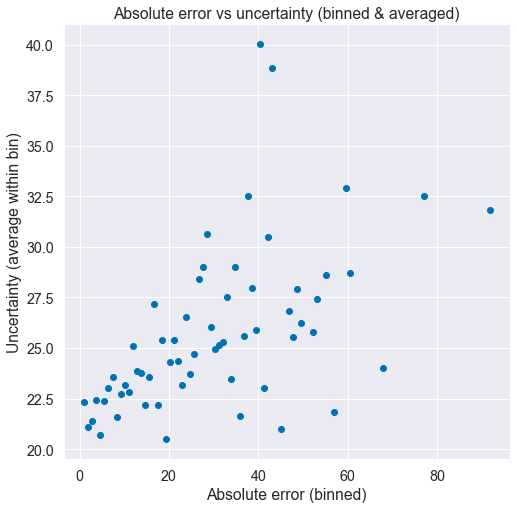

In [73]:
ax = plot_absolute_error_vs_uncertainty(y_val, y_hat, std, binned=True)

ax.set_title('Absolute error vs uncertainty (binned & averaged)');
ax.set_xlabel('Absolute error (binned)');
ax.set_ylabel('Uncertainty (average within bin)');

In [74]:
def plot_results_with_uncertainty(y_true, y_pred, y_pred_std, subset):
    _, ax = plt.subplots(1, 1, figsize=(7, 7))
    palette = sns.color_palette()
    
    min_value = min(np.amin(y_true), np.amin(y_pred))
    max_value = max(np.amax(y_true), np.amax(y_pred))
    y_mid = np.linspace(min_value, max_value)
    
    ax.plot(y_mid, y_mid, '--', color=palette[1])
    
    ax.scatter(y_true, y_pred, color=palette[0], alpha=0.1);
    
    ax.errorbar(y_true[subset], y_pred[subset], yerr=y_pred_std[subset], color=palette[0], fmt='o')
    
    return ax

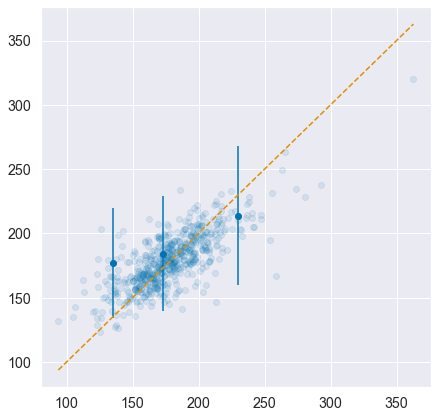

In [75]:
ix = [i for i, v in enumerate(stds) if v > stds.mean() + 3 * stds.std()]

plot_results_with_uncertainty(
    y_val.detach().numpy().flatten(),
    y_hat.detach().numpy().flatten(),
    std.detach().numpy().flatten(),
    subset=ix,
);

### Uncertainty on an input not yet seen & very different from the rest of the dataset

We'll consider an input composed of the maximum of all features.

In [111]:
random_input_np = np.zeros((1, x_val.shape[1]))
for i in range(x_val.shape[1]):
    fn = torch.amax
    random_input_np[0, i] = fn(x_val[:, i]) * 2
    
random_input = torch.from_numpy(random_input_np)
random_input.shape

torch.Size([1, 28])

In [116]:
_, std_epistemic, std_aleatoric = make_predictions(model, random_input)
uncertainty = float((std_epistemic + std_aleatoric).detach().numpy())
print(f'Uncertainty on made up input: {uncertainty:.2f}')

Uncertainty on made up input: 863.15


Uncertainty is high, which is what we want!